<a href="https://colab.research.google.com/github/tlk888/Yandex_ML-contest3_25s/blob/main/homeworks/hw01_classification/02_hw_fmnist_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Классификация FashionMNIST

##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), https://t.me/s/girafe_ai

In [17]:
# do not change the code in the block below
# __________start of block__________
import json
import os
import re

import numpy as np
import torch
import torchvision
from IPython.display import clear_output
from matplotlib import pyplot as plt
from torch import nn
from torch.nn import functional as F
from torchvision.datasets import FashionMNIST

# __________end of block__________

In [18]:
# do not change the code in the block below
# __________start of block__________


def parse_pytorch_model(model_str):
    def parse_layer(layer_str):
        layer_info = {}
        layer_name, params = layer_str.split("(", 1)
        params = params.rstrip(")")
        layer_info["type"] = layer_name.strip()
        param_dict = {}
        for param in params.split(", "):
            if "=" in param:
                key, value = param.split("=")
                param_dict[key.strip()] = eval(value.strip())
            else:
                param_dict[param.strip()] = None
        layer_info["parameters"] = param_dict
        return layer_info

    model_dict = {}
    lines = model_str.splitlines()
    model_name = lines[0].strip("()")
    model_dict["model_name"] = model_name
    model_dict["layers"] = []

    layer_regex = re.compile(r"\((\d+)\): (.+)")
    for line in lines[1:]:
        line = line.strip()
        match = layer_regex.match(line)
        if match:
            index, layer = match.groups()
            model_dict["layers"].append({"index": int(index), "layer": parse_layer(layer)})
    return model_dict


# __________end of block__________

In [19]:
# do not change the code in the block below
# __________start of block__________
def get_predictions(model, eval_data, step=10):

    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for idx in range(0, len(eval_data), step):
            y_predicted = model(eval_data[idx : idx + step].to(device))
            predicted_labels.append(y_predicted.argmax(dim=1).cpu())

    predicted_labels = torch.cat(predicted_labels)
    predicted_labels = ",".join([str(x.item()) for x in list(predicted_labels)])
    return predicted_labels


def get_accuracy(model, data_loader):
    predicted_labels = []
    real_labels = []
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            y_predicted = model(batch[0].to(device))
            predicted_labels.append(y_predicted.argmax(dim=1).cpu())
            real_labels.append(batch[1])

    predicted_labels = torch.cat(predicted_labels)
    real_labels = torch.cat(real_labels)
    accuracy_score = (predicted_labels == real_labels).type(torch.FloatTensor).mean()
    return accuracy_score


# __________end of block__________

Загрузите файл `hw_overfitting_data_dict.npy` (ссылка есть на странице с заданием), он понадобится для генерации посылок. Код ниже может его загрузить (но в случае возникновения ошибки скачайте и загрузите его вручную).


In [4]:
!wget https://github.com/girafe-ai/ml-course/raw/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict -O hw_overfitting_data_dict.npy

--2025-04-08 20:40:54--  https://github.com/girafe-ai/ml-course/raw/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/girafe-ai/ml-course/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict [following]
--2025-04-08 20:40:55--  https://raw.githubusercontent.com/girafe-ai/ml-course/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6272446 (6.0M) [application/octet-stream]
Saving to: ‘hw_overfitting_data_dict.npy’

hw_overfitting_data 100%[===================>]   5.98M  --.-KB/s 

In [20]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_overfitting_data_dict.npy"
), "Please, download `hw_overfitting_data_dict.npy` and place it in the working directory"

# __________end of block__________

Вернемся к задаче распознавания простых изображений, рассмотренной ранее. Но теперь будем работать с набором данных [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). В данном задании воспользуемся всем датасетом целиком.

__Ваша первая задача: реализовать весь пайплан обучения модели и добиться качества $\geq 88.5\%$ на тестовой выборке.__

Код для обучения модели в данном задании отсутствует. Присутствует лишь несколько тестов, которые помогут вам отладить свое решение. За примером можно обратиться к ноутбукам с предыдущих занятий.

In [21]:
CUDA_DEVICE_ID = 0  # change if needed

In [22]:
# do not change the code in the block below
# __________start of block__________
device = (
    torch.device(f"cuda:{CUDA_DEVICE_ID}") if torch.cuda.is_available() else torch.device("cpu")
)
# __________end of block__________

Text(0.5, 1.0, 'Image label: 5')

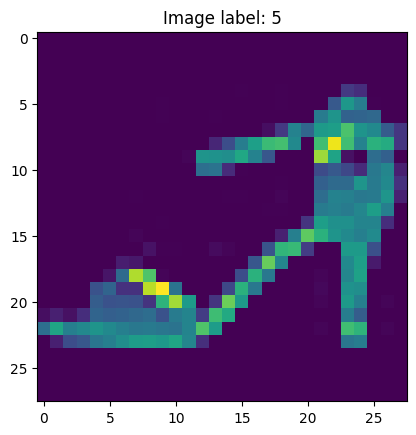

In [23]:
# do not change the code in the block below
# __________start of block__________

train_fmnist_data = FashionMNIST(
    ".", train=True, transform=torchvision.transforms.ToTensor(), download=True
)
test_fmnist_data = FashionMNIST(
    ".", train=False, transform=torchvision.transforms.ToTensor(), download=True
)


train_data_loader = torch.utils.data.DataLoader(
    train_fmnist_data, batch_size=32, shuffle=True, num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_fmnist_data, batch_size=32, shuffle=False, num_workers=2
)

random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f"Image label: {_label}")
# __________end of block__________

Постройте модель ниже. Пожалуйста, не стройте переусложненную сеть, не стоит делать ее глубже четырех слоев (можно и меньше). Ваша основная задача – обучить модель и получить качество на отложенной (тестовой выборке) не менее 88.5% accuracy.

__Внимание, ваша модель должна быть представлена именно переменной `model_task_1`. На вход ей должен приходить тензор размерностью (1, 28, 28).__

In [61]:
# Creating model instance
model_task_1 = None

class WSConv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, **kwargs):
        super().__init__(in_channels, out_channels, kernel_size, **kwargs)
        nn.init.kaiming_normal_(self.weight)

    def forward(self, x):
        weight = self.weight
        weight_mean = weight.mean(dim=(1,2,3), keepdim=True)
        weight_std = weight.std(dim=(1,2,3), keepdim=True)
        standardized_weight = (weight - weight_mean) / (weight_std + 1e-5)
        return F.conv2d(
            x, standardized_weight, self.bias,
            self.stride, self.padding, self.dilation, self.groups
        )

# Creating model instance
class FashionMNISTModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            WSConv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            WSConv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.net(x)

model_task_1 = FashionMNISTModel()

Не забудьте перенести модель на выбранный `device`!

In [62]:
model_task_1.to(device)

FashionMNISTModel(
  (net): Sequential(
    (0): WSConv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): WSConv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=3136, out_features=128, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.5, inplace=False)
    (10): Linear(in_features=128, out_features=10, bias=True)
  )
)

Локальные тесты для проверки вашей модели доступны ниже:

In [63]:
# do not change the code in the block below
# __________start of block__________
assert model_task_1 is not None, "Please, use `model_task_1` variable to store your model"

try:
    x = random_batch[0].to(device)
    y = random_batch[1].to(device)

    # compute outputs given inputs, both are variables
    y_predicted = model_task_1(x)
except Exception as e:
    print("Something is wrong with the model")
    raise e


assert y_predicted.shape[-1] == 10, "Model should predict 10 logits/probas"

print("Everything seems fine!")
# __________end of block__________

Everything seems fine!


Настройте параметры модели на обучающей выборке. Также рекомендуем поработать с `learning rate`.

In [64]:
# Гиперпараметры
LEARNING_RATE = 0.00005
EPOCHS = 30
PATIENCE = 5

# Инициализация компонентов обучения
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_task_1.parameters(), lr=LEARNING_RATE, weight_decay=3e-4)
#optimizer = torch.optim.SGD(
#    model_task_1.parameters(),
#    lr=LEARNING_RATE,         # Начальный learning rate
#    momentum=0.9,     # Добавляем momentum
#    nesterov=True,    # Включаем Nesterov acceleration
#    weight_decay=5e-4
#)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2, factor=0.2, min_lr=1e-6)
#scheduler = torch.optim.lr_scheduler.CyclicLR(
#    optimizer,
#    base_lr=0.00005,
#    max_lr=0.01,
#    step_size_up=1000,
#    mode='triangular2'
#)

best_accuracy = 0.0
no_improve = 0
prev_lr = LEARNING_RATE  # Для отслеживания изменения LR

# Цикл обучения
for epoch in range(EPOCHS):
    model_task_1.train()
    running_loss = 0.0

    for images, labels in train_data_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_task_1(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    # Валидация
    model_task_1.eval()
    test_accuracy = get_accuracy(model_task_1, test_data_loader)
    epoch_loss = running_loss / len(train_data_loader.dataset)

    # Обновление LR с ручным отслеживанием
    scheduler.step(test_accuracy)
    current_lr = optimizer.param_groups[0]['lr']

    # Вывод информации об изменении LR
    if current_lr != prev_lr:
        print(f"\nLearning rate reduced to {current_lr:.2e}")
        prev_lr = current_lr

    # Логирование
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {epoch_loss:.4f} | Test Accuracy: {test_accuracy:.4f} | LR: {current_lr:.2e}")

    # Ранняя остановка и сохранение модели
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        torch.save(model_task_1.state_dict(), "best_model.pth")
        no_improve = 0
        if test_accuracy >= 0.985:
            print("\nTarget accuracy reached!")
            break
    else:
        no_improve += 1
        if no_improve == PATIENCE:
            print("\nEarly stopping triggered")
            break

# Загрузка лучшей модели
model_task_1.load_state_dict(torch.load("best_model.pth"))
final_accuracy = get_accuracy(model_task_1, test_data_loader)
print(f"\nFinal Test Accuracy: {final_accuracy:.4f}")


Epoch 1/30
Train Loss: 0.6281 | Test Accuracy: 0.8622 | LR: 5.00e-05

Epoch 2/30
Train Loss: 0.4174 | Test Accuracy: 0.8792 | LR: 5.00e-05

Epoch 3/30
Train Loss: 0.3636 | Test Accuracy: 0.8887 | LR: 5.00e-05

Epoch 4/30
Train Loss: 0.3266 | Test Accuracy: 0.8940 | LR: 5.00e-05

Epoch 5/30
Train Loss: 0.3049 | Test Accuracy: 0.8979 | LR: 5.00e-05

Epoch 6/30
Train Loss: 0.2821 | Test Accuracy: 0.9020 | LR: 5.00e-05

Epoch 7/30
Train Loss: 0.2653 | Test Accuracy: 0.9046 | LR: 5.00e-05

Epoch 8/30
Train Loss: 0.2540 | Test Accuracy: 0.9084 | LR: 5.00e-05

Epoch 9/30
Train Loss: 0.2422 | Test Accuracy: 0.9056 | LR: 5.00e-05

Epoch 10/30
Train Loss: 0.2300 | Test Accuracy: 0.9069 | LR: 5.00e-05

Epoch 11/30
Train Loss: 0.2211 | Test Accuracy: 0.9091 | LR: 5.00e-05

Epoch 12/30
Train Loss: 0.2117 | Test Accuracy: 0.9142 | LR: 5.00e-05

Epoch 13/30
Train Loss: 0.2030 | Test Accuracy: 0.9137 | LR: 5.00e-05

Epoch 14/30
Train Loss: 0.1963 | Test Accuracy: 0.9149 | LR: 5.00e-05

Epoch 15/30
Tr

Также, напоминаем, что в любой момент можно обратиться к замечательной [документации](https://pytorch.org/docs/stable/index.html) и [обучающим примерам](https://pytorch.org/tutorials/).  

Оценим качество классификации:

In [65]:
train_acc_task_1 = get_accuracy(model_task_1, train_data_loader)
print(f"Neural network accuracy on train set: {train_acc_task_1:3.5}")

Neural network accuracy on train set: 0.96877


In [66]:
test_acc_task_1 = get_accuracy(model_task_1, test_data_loader)
print(f"Neural network accuracy on test set: {test_acc_task_1:3.5}")

Neural network accuracy on test set: 0.9236


Проверка, что необходимые пороги пройдены:

In [67]:
assert test_acc_task_1 >= 0.885, "Train accuracy is below 0.885 threshold"
assert (
    train_acc_task_1 >= 0.905
), "Train accuracy is below 0.905 while test accuracy is fine. We recommend to check your model and data flow"

def class_wise_accuracy(model, test_loader, num_classes=10):
    model.eval()
    correct_pred = {class_idx: 0 for class_idx in range(num_classes)}
    total_pred = {class_idx: 0 for class_idx in range(num_classes)}

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predictions = torch.max(outputs, 1)

            # Update counts for each class
            for label, prediction in zip(labels, predictions):
                class_idx = label.item()
                total_pred[class_idx] += 1
                if prediction == label:
                    correct_pred[class_idx] += 1

    # Calculate accuracy for each class
    class_acc = {}
    for class_idx in range(num_classes):
        if total_pred[class_idx] > 0:
            acc = 100 * correct_pred[class_idx] / total_pred[class_idx]
            class_acc[class_idx] = acc
        else:
            class_acc[class_idx] = 0.0  # Handle case with zero samples

    # Calculate overall accuracy
    total_correct = sum(correct_pred.values())
    total_samples = sum(total_pred.values())
    overall_acc = 100 * total_correct / total_samples

    return class_acc, overall_acc

class_acc, overall_acc = class_wise_accuracy(model_task_1, test_data_loader)

# Вывод результатов
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print(f"Overall Test Accuracy: {overall_acc:.2f}%")
print("\nClass-wise Accuracy:")
for idx, name in enumerate(class_names):
    print(f"{name:15}: {class_acc[idx]:.2f}%")

Overall Test Accuracy: 92.36%

Class-wise Accuracy:
T-shirt/top    : 89.10%
Trouser        : 98.60%
Pullover       : 88.00%
Dress          : 92.40%
Coat           : 90.10%
Sandal         : 98.50%
Shirt          : 74.60%
Sneaker        : 97.70%
Bag            : 98.50%
Ankle boot     : 96.10%


Обращаем внимане, код ниже предполагает, что ваша модель имеет содержится в переменной `model_task_1`, а файл `hw_fmnist_data_dict.npy` находится в той же директории, что и ноутбук (он доступен в репозитории).

In [69]:
import re
import ast

def parse_pytorch_model(model_str):
    def parse_layer(layer_str):
        layer_info = {}
        parts = layer_str.split("(", 1)
        layer_name = parts[0].strip()
        layer_info["type"] = layer_name

        if len(parts) == 1:
            layer_info["parameters"] = {}
            return layer_info

        params_str = parts[1].rstrip(")")
        param_dict = {}
        current_param = []
        in_brackets = 0

        for char in params_str + ",":
            if char == "(":
                in_brackets += 1
                current_param.append(char)
            elif char == ")":
                in_brackets -= 1
                current_param.append(char)
            elif char == "," and in_brackets == 0:
                param = "".join(current_param).strip()
                if param:
                    if "=" in param:
                        key, value = param.split("=", 1)
                        key = key.strip()
                        value = value.strip()
                        try:
                            param_dict[key] = ast.literal_eval(value)
                        except:
                            param_dict[key] = value
                    else:
                        param_dict[param] = None
                current_param = []
            else:
                current_param.append(char)

        layer_info["parameters"] = param_dict
        return layer_info

    # Обработка входных данных
    lines = [line.strip() for line in model_str.splitlines() if line.strip()]
    if not lines:
        return {"model_name": "Unknown", "layers": []}

    # Извлекаем имя модели из первой строки (новый способ)
    model_name = lines[0].split("(", 1)[0].strip()
    model_dict = {
        "model_name": model_name,
        "layers": []
    }

    # Регулярное выражение для слоев
    layer_pattern = re.compile(r"\((\w+)\):\s*(\w+)\((.*)\)")

    for line in lines[1:]:
        if line.startswith("(") and "):" in line:
            match = layer_pattern.match(line)
            if match:
                layer_name, layer_type, params = match.groups()
                try:
                    layer_info = parse_layer(f"{layer_type}({params})")
                    model_dict["layers"].append({
                        "name": layer_name,
                        "type": layer_type,
                        "parameters": layer_info["parameters"]
                    })
                except Exception as e:
                    print(f"Error parsing layer {layer_name}: {str(e)}")

    return model_dict


# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_fmnist_data_dict.npy"
), "Please, download `hw_fmnist_data_dict.npy` and place it in the working directory"

loaded_data_dict = np.load("hw_fmnist_data_dict.npy", allow_pickle=True)

submission_dict = {
    "train_predictions_task_1": get_predictions(
        model_task_1, torch.FloatTensor(loaded_data_dict.item()["train"])
    ),
    "test_predictions_task_1": get_predictions(
        model_task_1, torch.FloatTensor(loaded_data_dict.item()["test"])
    ),
    "model_task_1": parse_pytorch_model(str(model_task_1)),
}

with open("submission_dict_fmnist_task_1.json", "w") as iofile:
    json.dump(submission_dict, iofile)
print("File saved to `submission_dict_fmnist_task_1.json`")
# __________end of block__________

File saved to `submission_dict_fmnist_task_1.json`


### Сдача задания
Сдайте сгенерированный файл в соответствующую задачу в соревновании, а именно:
    
* `submission_dict_fmnist_task_1.json` в задачу Separation

На этом задание завершено. Поздравляем!